In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

import os
dir='/root/autodl-tmp/cache/'
os.environ["HF_DATASETS_CACHE"] = dir
os.environ["HF_HOME"] = dir
os.environ["HUGGINGFACE_HUB_CACHE"] = dir
os.environ["TRANSFORMERS_CACHE"] = dir

#!unset http_proxy && unset https_proxy

In [2]:
import torch
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"


/root/miniconda3/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
transformers_config = TransformersConfig(
    model=AutoModelForCausalLM.from_pretrained('Qwen/Qwen2.5-0.5B').to(device),
    tokenizer=AutoTokenizer.from_pretrained('Qwen/Qwen2.5-0.5B'),
    # vocab_size=50272,
    device=device,
    max_new_tokens=100,
    min_length=20,
    do_sample=True,
    # no_repeat_ngram_size=4
)


In [4]:
wm1 = AutoWatermark.load(
    'KGW', 
    algorithm_config='config/KGW.json',
    transformers_config=transformers_config
)
# wm2 = AutoWatermark.load(
#     'KGW', 
#     algorithm_config='config/KGW_.json',
#     transformers_config=transformers_config
# )


In [5]:
import paraphrasing
prompt1 ="Paris is a city with "
wm=paraphrasing.Watermarker(wm1)
wm1_ans,sc = wm.generate_wm_text(prompt1)
print(wm1_ans)
print(sc)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


148 years in the art scene and an international reputation of artists and art fairs, but it also ranks third of countries for the number of outstanding artists in the world according to art associations.
Paris has long given prominence to European artists like Edvard Munch, Max Ernst, Edouard Manet, Paul Cret’s, Max Beckmann, Wassily Kandinsky, Charles Marville, Georges Braque and a number of others. It is well-known for the Parisian Acad
5.3267004208738244


In [6]:
paraphraser=paraphrasing.ParaphrasingAttacker(cfg='config/Qwen.toml')
# print(paraphraser.args)
ans=paraphraser.pipeline_paraphrase(wm1_ans)
print(ans)
para_sc=wm.detect_score(ans)
print(para_sc)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Paris has been a significant player in the art world for over 148 years, hosting numerous international art fairs and boasting an impressive roster of renowned artists. It ranks third in the world for the number of outstanding artists according to art associations. The city has been home to numerous influential artists, including Edvard Munch, Max Ernst, Edouard Manet, Paul Cret, Max Beckmann, Wassily Kandinsky, Charles Marville, Georges Braque, and many others.
2.4


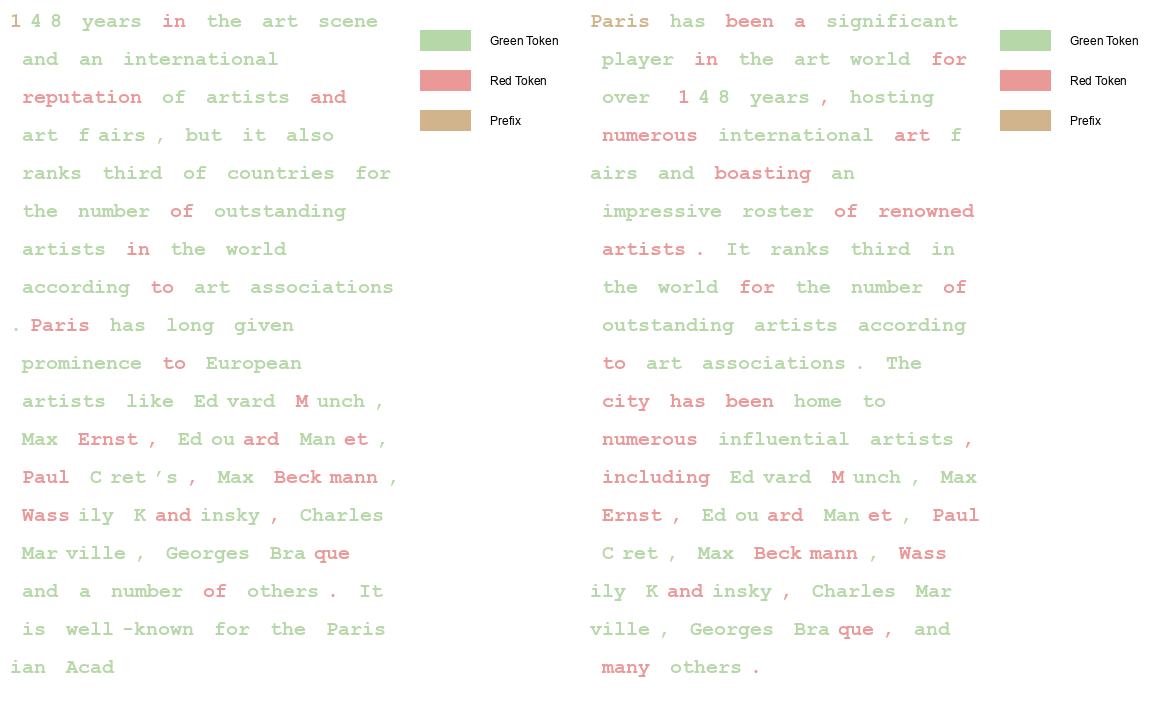

In [7]:
paraphrasing.Watermarker.contact_viz(
    wm.viz(wm1_ans,savepath='viz/KGW_pre.png'),
    wm.viz(ans,savepath='viz/KGW_post.png')
)

In [8]:
import pandas as pd
d=dict(
    ori_text=[wm1_ans],
    ori_score=[sc],
    para_text=[ans],
    para_score=[para_sc],
    
)
df=pd.DataFrame(d)
df.to_csv('paraphrase_attack.csv')